In [1]:
import chess
import chess.engine
import os
import sys
import chess.pgn
import subprocess

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

import utils.chess_utils as chess_utils
from utils.pikeBot_chess_utils import *
from utils.utils import *
config=get_paths()
stockfish_path=config['stockfish_path']
maia_path=config['maia_path']
from evaluation_utils import *

In [2]:
def get_maia_path(maia_elo):
    version=int(str(maia_elo)[1])
    if version not in [1,5,9]:
        raise ValueError("Maia elo must be from (1100, 1500, 1900)")
    else:
        return maia_path.format(version=version)


In [3]:
class MaiaChess(chess_utils.Player):
    def __init__(self, maia_path: str) -> None:
        super().__init__()
        #redirect error stderr not to display messages from the engine
        self.engine = chess.engine.SimpleEngine.popen_uci(maia_path, stderr=subprocess.DEVNULL)

    def get_best_move(self, board):
        result = self.engine.play(board, chess.engine.Limit(nodes=1))
        move = result.move
        return move

### Parameters setup
set path parameters to your local resources and evaluation parameters depending on your evaluation setup

In [4]:
model_path = config['pikebot']
preprocessing_parameters_path = config['preprocessing_params_path']

#evaluation parameters
time_limit = 0.01
evaluation_dataset_paths = [
    'games/silversuite.pgn',
    ]

### Engine definition
By default engine1 is a maia chess engine simulating human behavior but you can modify it if you want other engine comparison. Both engines must be of a child class of chess_utils.Player.

In [5]:
maia_path

'D:/Krzysiaczek/Documents/studia/engeneering/MaiaChess/Maia{version}/lc0.exe'

In [6]:
maia_elo = 1100
maia_path = get_maia_path(maia_elo)
engine1 = MaiaChess(maia_path)

In [7]:
from Pikebot.PikeBotHeuristic3 import PikeBotHeuristic3
from Pikebot.PikeBotHeuristic4 import PikeBotHeuristic4
from utils.pikeBot_chess_utils import *
model = PikeBotModelWrapper(model_path, preprocessing_parameters_path)
engine2 = PikeBotHeuristic3(
    model,
    chess_utils.max_aggr,
    stockfish_path
)

### Dataset loading

In [8]:
boards_datasets = dict()
for path in evaluation_dataset_paths:
    boards_dataset = get_boards_dataset(path)

    boards_datasets[path] = boards_dataset


In [9]:
boards_datasets['games/silversuite.pgn'] = boards_datasets['games/silversuite.pgn'][:2]

### Evaluation code

In [10]:
def evaluate(engine1, engine2, boards_datasets, elo1, elo2):
    for path, boards_dataset in boards_datasets.items():
        result1, boards1 = compare_engines(engine1, engine2, boards_dataset)
        result2, boards2 = compare_engines(engine2, engine1, boards_dataset)

        name1, name2 = type(engine1).__name__, type(engine2).__name__
        
        #define saving directory
        path_to_save = path.replace('games/', '')
        path_to_save = path_to_save.replace('.pgn', '')
        timestamp = time.asctime().replace(' ', '_')
        timestamp = timestamp.replace(':', '-')

        dir_path = f'{name1}_{name2}_{path_to_save}_{timestamp}'
        os.makedirs(f'results/{dir_path}', exist_ok=True) 
        os.makedirs(f'results/{dir_path}/games', exist_ok=True) 
        os.makedirs(f'results/{dir_path}/statistics', exist_ok=True) 
        os.makedirs(f'results/{dir_path}/plots', exist_ok=True) 

        #get move evaluation and save games
        evaluation1 = process_games(boards1, name1, name2, dir_path, elo1, elo2)
        evaluation2 = process_games(boards2, name2, name1, dir_path, elo2, elo1)

        #plot results and save plots
        process_results(result1, name1, name2, dir_path)
        process_results(result2, name2, name1, dir_path)

        process_evaluation(evaluation1, name1, name2, dir_path)
        process_evaluation(evaluation2, name2, name1, dir_path)

        process_length(boards1, name1, name2, dir_path) 
        process_length(boards2, name2, name1, dir_path) 

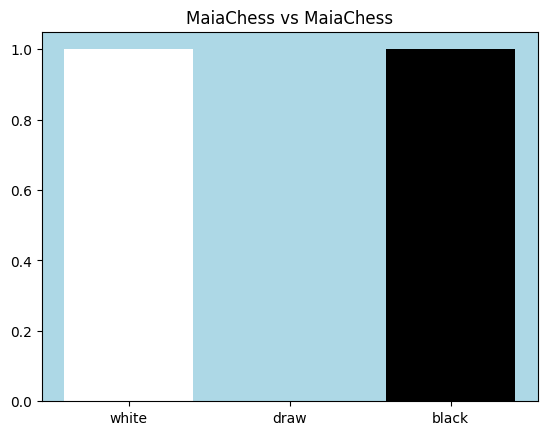

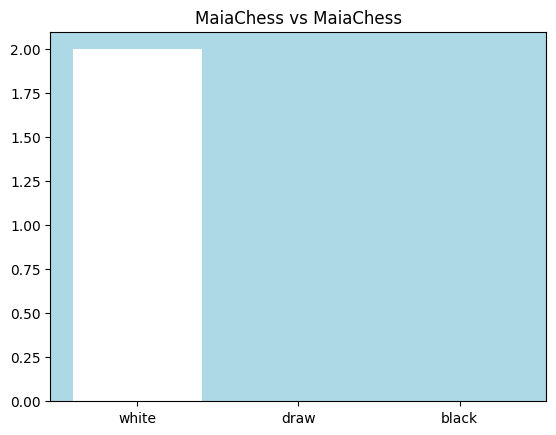

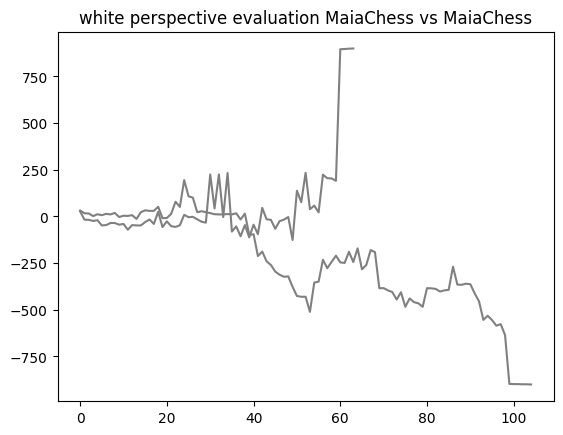

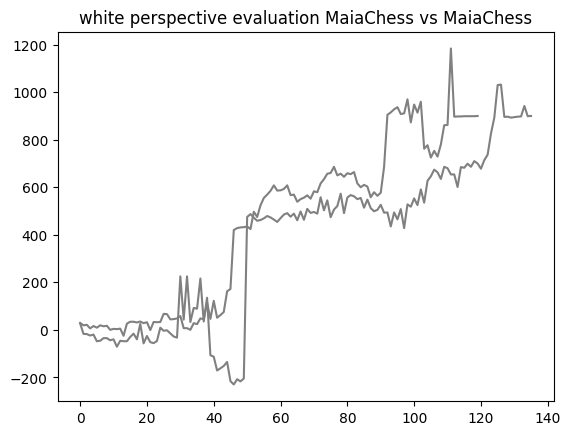

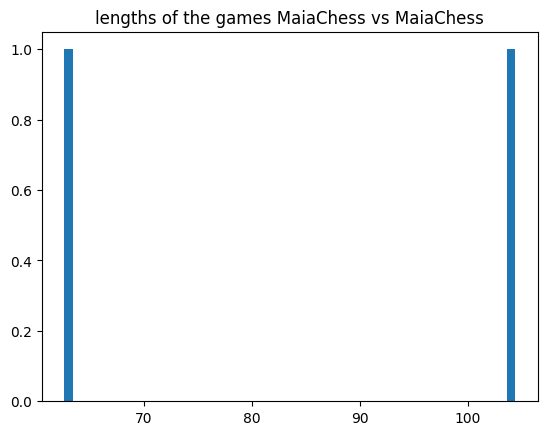

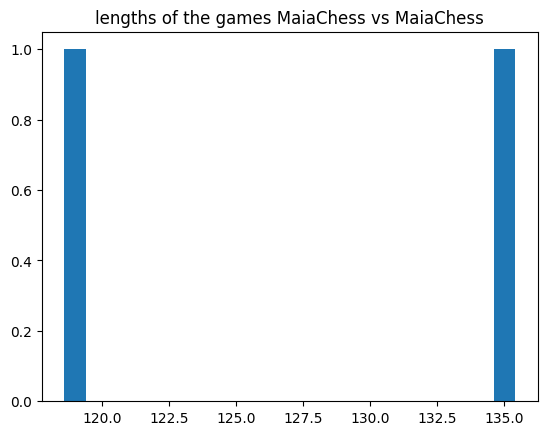

In [11]:
evaluate(engine1, engine1, boards_datasets, maia_elo, 800)

In [8]:
engine2 = PikeBotHeuristic4(
    model,
    chess_utils.max_aggr,
    stockfish_path
)